# Import Library

In [1]:
import numpy as np
import pandas as pd 
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os
print(os.listdir("./input"))

Using TensorFlow backend.
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

['sampleSubmission.csv', 'test1', 'train']


# Read Data

In [2]:
filenames = os.listdir("./input/train/")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

# Data Exploration

In [3]:
df.head()

,filename,category
0,cat.0.jpg,0
1,cat.1.jpg,0
2,cat.10.jpg,0
3,cat.100.jpg,0
4,cat.1000.jpg,0


In [4]:
df.tail()

,filename,category
24995,dog.9995.jpg,1
24996,dog.9996.jpg,1
24997,dog.9997.jpg,1
24998,dog.9998.jpg,1
24999,dog.9999.jpg,1


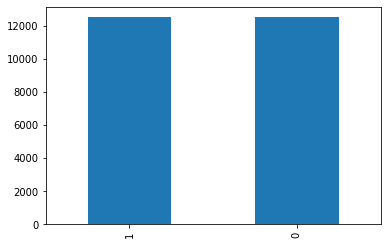

In [5]:
# Total Number of Data
df['category'].value_counts().plot.bar()

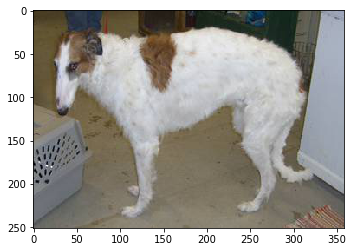

In [6]:
# See Example
sample = random.choice(filenames)
image = load_img("./input/train/"+sample)
plt.imshow(image)

# Data Preprocessing
* Train-Test Split
* Data Augumentation (Image Generator)

### Train-Test Split

In [7]:
df["category"] = df["category"].replace({0: 'cat', 1: 'dog'}) 
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

In [8]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15

# Data Augumentation

In [9]:
FAST_RUN = False
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

In [10]:
# Add more Image Data
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "./input/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

# Output validation Data
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "./input/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 20000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.


Found 1 validated image filenames belonging to 1 classes.


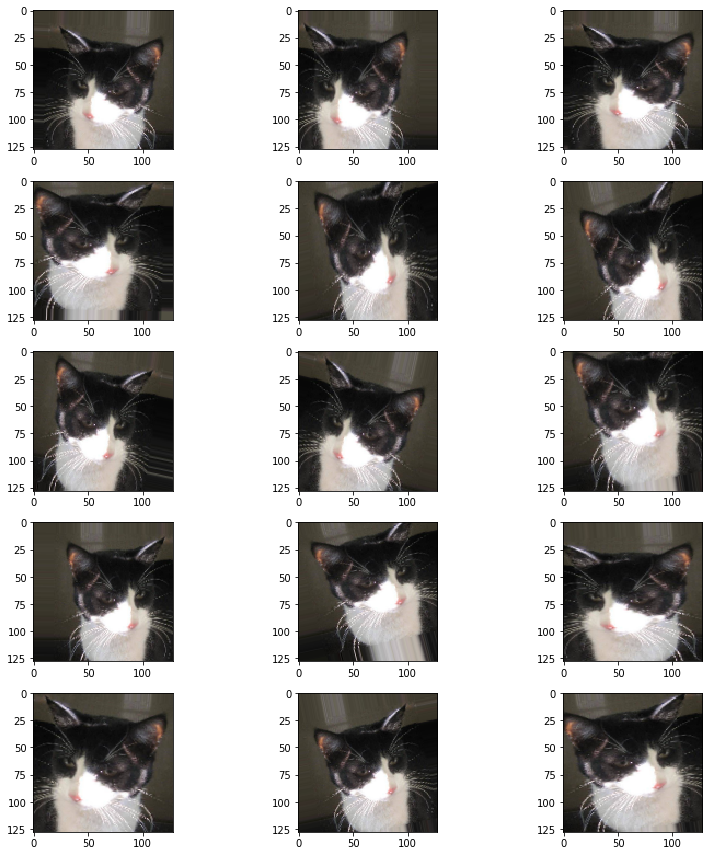

In [11]:
# Example of image data
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    "./input/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

# plot
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

# Build Model

In [12]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
from keras import backend as K
K.tensorflow_backend._get_available_gpus()
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax')) # 2 because we have cat and dog classes

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 61, 61, 64)        256       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 64)      

# Model Training
* Early Stop
* Model Fit
* Training Result
* Save Model

### Early Stop

In [13]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
earlystop = EarlyStopping(patience=10)

In [14]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [15]:
callbacks = [earlystop, learning_rate_reduction]

### Model Fitting

In [16]:
epochs=3 if FAST_RUN else 50
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)


Epoch 1/50
1333/1333 [==============================] - 219s 164ms/step - loss: 0.7270 - accuracy: 0.6399 - val_loss: 0.6463 - val_accuracy: 0.7211
Epoch 2/50
   1/1333 [..............................] - ETA: 2:53 - loss: 0.3739 - accuracy: 0.8667

C:\Users\sys_0\AppData\Roaming\Python\Python37\site-packages\keras\callbacks\callbacks.py:1042: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


1333/1333 [==============================] - 208s 156ms/step - loss: 0.5427 - accuracy: 0.7340 - val_loss: 0.6242 - val_accuracy: 0.7781
Epoch 3/50
1333/1333 [==============================] - 213s 160ms/step - loss: 0.4908 - accuracy: 0.7673 - val_loss: 0.5717 - val_accuracy: 0.6630
Epoch 4/50
1333/1333 [==============================] - 216s 162ms/step - loss: 0.4589 - accuracy: 0.7900 - val_loss: 2.2751 - val_accuracy: 0.5334
Epoch 5/50
1333/1333 [==============================] - 195s 147ms/step - loss: 0.4343 - accuracy: 0.8038 - val_loss: 0.5137 - val_accuracy: 0.8215
Epoch 6/50
1333/1333 [==============================] - 194s 146ms/step - loss: 0.4193 - accuracy: 0.8115 - val_loss: 0.3273 - val_accuracy: 0.8305
Epoch 7/50
1333/1333 [==============================] - 199s 149ms/step - loss: 0.4005 - accuracy: 0.8216 - val_loss: 0.3068 - val_accuracy: 0.7974
Epoch 8/50
1333/1333 [==============================] - 199s 149ms/step - loss: 0.3888 - accuracy: 0.8310 - val_loss: 0.337

### Visualize Tranining Result

In [19]:
history.history

{'val_loss': [0.6462789177894592,
  0.6241772770881653,
  0.5716804265975952,
  2.2751033306121826,
  0.5137260556221008,
  0.327256977558136,
  0.3068214952945709,
  0.33736929297447205,
  0.6841279864311218,
  0.3307094871997833,
  0.25873246788978577,
  0.15121272206306458,
  0.24850264191627502,
  0.1546068787574768,
  0.3927692770957947,
  0.18155591189861298,
  0.16190607845783234,
  0.4862337112426758,
  0.37725791335105896,
  0.11354952305555344,
  0.07404403388500214,
  1.1832555532455444,
  0.1735449731349945,
  0.45998290181159973,
  0.1211707815527916,
  1.3509140014648438,
  0.15207518637180328,
  0.15272997319698334,
  0.3675104081630707,
  0.4091378450393677,
  0.46242979168891907],
 'val_accuracy': [0.7211211323738098,
  0.7781344056129456,
  0.6629889607429504,
  0.5334001779556274,
  0.8214644193649292,
  0.8304914832115173,
  0.7973921895027161,
  0.829689085483551,
  0.7939819693565369,
  0.8631895780563354,
  0.7273821234703064,
  0.8200601935386658,
  0.8625877499

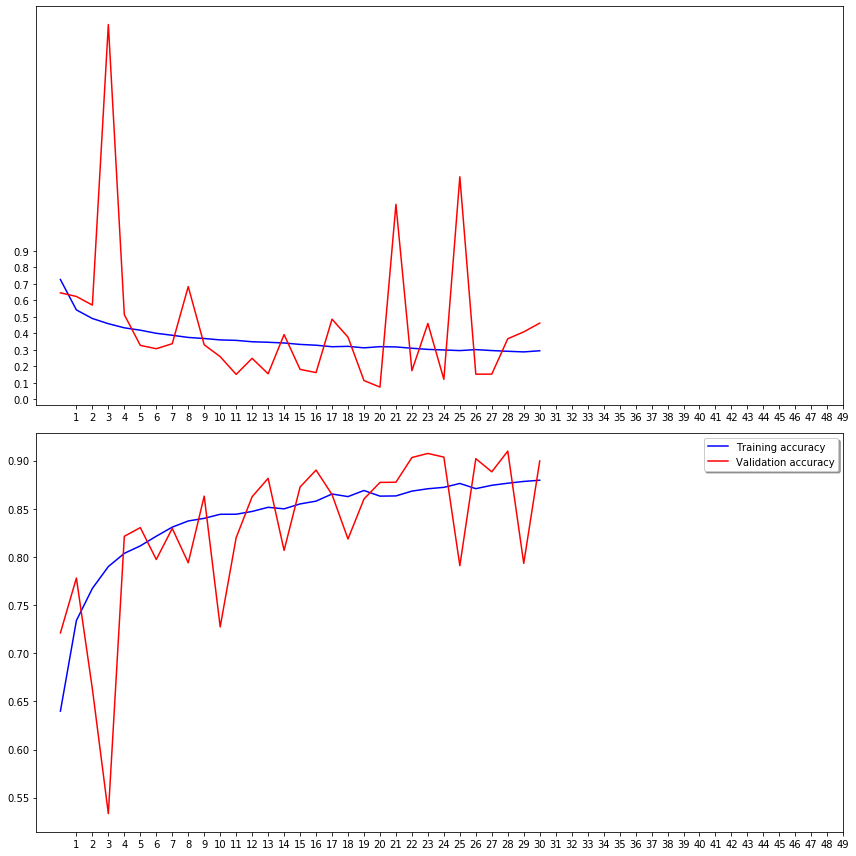

In [20]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

### Save Model

In [21]:
model.save_weights("model.h5")

# Validation
* Import Validating Data (Input + Data Generation)
* Prediction
* Prediction Result
* Vitualize Prediction Result

### Import Validating Data

In [22]:
test_filenames = os.listdir("./input/test1")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

In [24]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "./input/test1/", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 12500 validated image filenames.


### Prediction Progress

In [25]:
# Predict
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))
# Reduce one-hot to only one columns
test_df['category'] = np.argmax(predict, axis=-1)
# Mapping label from (0,1) => (cat,dog)
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)
test_df['category'] = test_df['category'].replace({ 'dog': 1, 'cat': 0 })

# Prediction Result

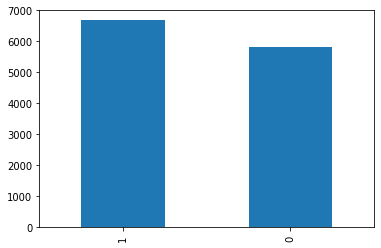

In [26]:
# barplot
test_df['category'].value_counts().plot.bar()

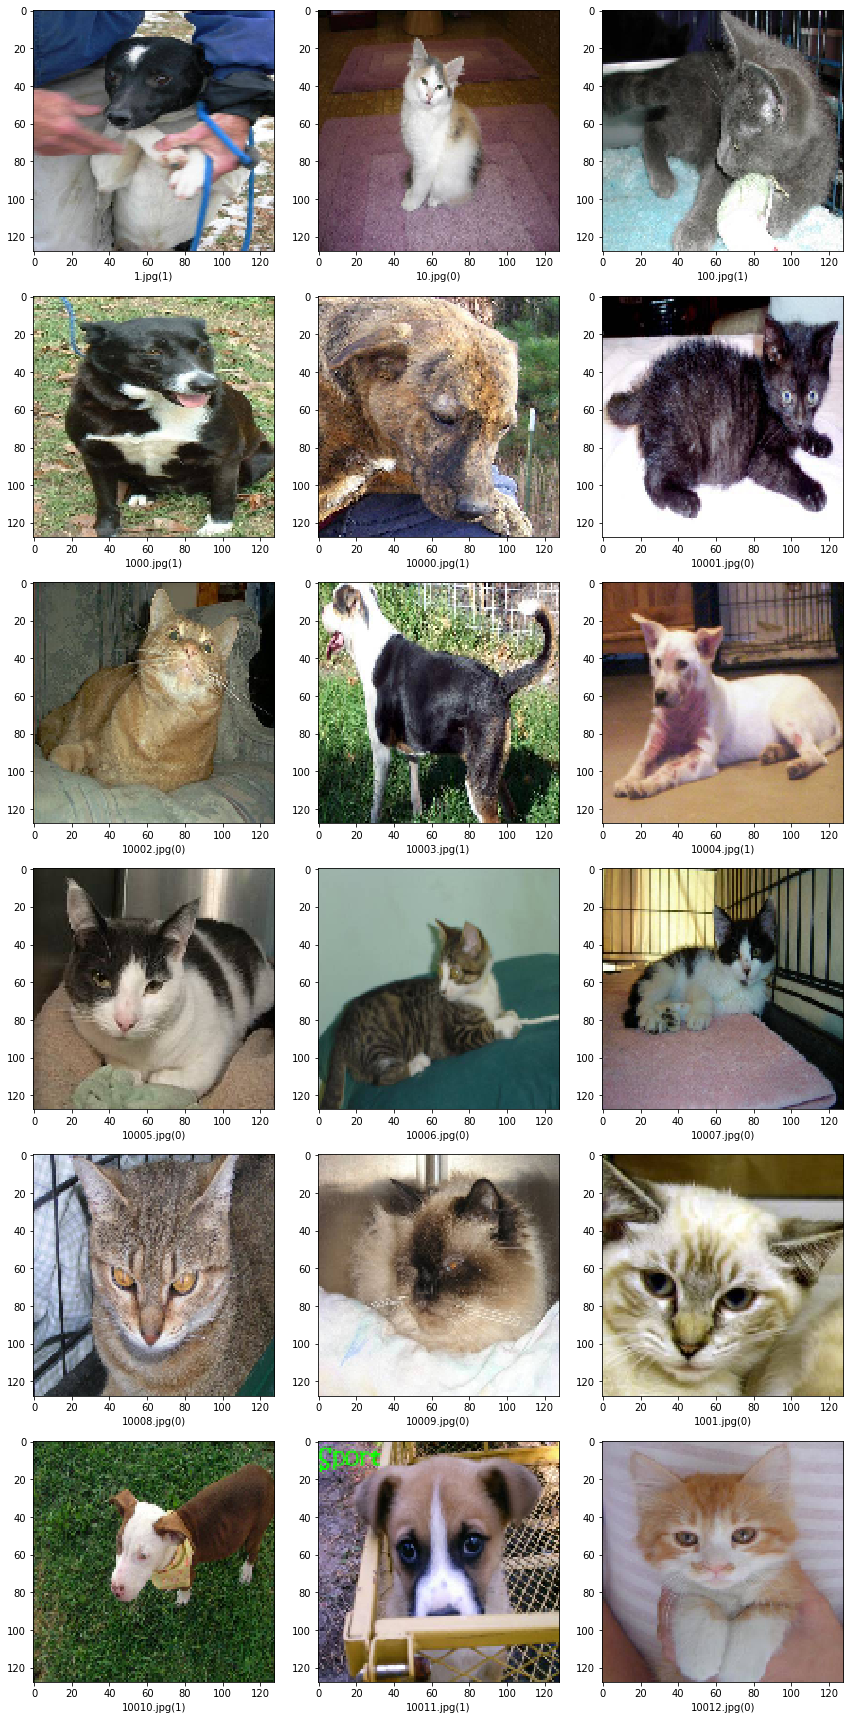

In [28]:
# Sample Test
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("./input/test1/"+filename, target_size=IMAGE_SIZE)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()

# Submission

In [30]:
submission_df = test_df.copy()
submission_df['id'] = submission_df['filename'].str.split('.').str[0]
submission_df['label'] = submission_df['category']
submission_df.drop(['filename', 'category'], axis=1, inplace=True)
submission_df.to_csv('submission.csv', index=False)